In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from jax import random
from jax.config import config

import logger as logging
logger = logging.init_logger(log_level=logging.INFO)

config.update("jax_enable_x64", True)
%matplotlib inline

# Model

In [2]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP
import jax.numpy as jnp
from snngp_inference import select_inducing_points
from metrics import RMSE

model = FCN
model_params = dict(
            kernel_batch_size=0, 
            device_count=-1, 
            num_layers=10,
            hid_dim=1, 
            out_dim=1,
            nonlinearity=stax.Relu
            )

2022-08-15 21:52:01.159882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib


# Dataset

In [3]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 5

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

X.shape, y.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (1000, 1), (1000, 1))

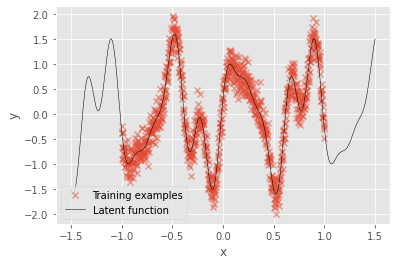

In [4]:
# X_m, indices = select_inducing_points("greedy", X, m, model, jnp.array([1, 1]), model_params)
X_m = X
plt.scatter(X, y, label='Training examples', marker='x', alpha=0.5)
# plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig("figures/1d_data.pdf", bbox_inches='tight')

[2022-08-13 15:11:02,793 INFO] (snngp_inference:58) inducing_points shape: (5, 1)


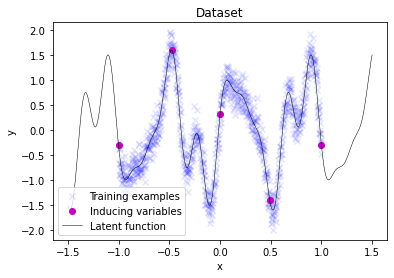

In [7]:
X_m, indices = select_inducing_points("greedy", X, m, model, jnp.array([10, 10]), model_params)

plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

[2022-08-11 16:24:30,199 INFO] (snngp_inference:59) inducing_points shape: (5, 1)
[2022-08-11 16:24:30,199 INFO] (snngp_inference:59) inducing_points shape: (5, 1)


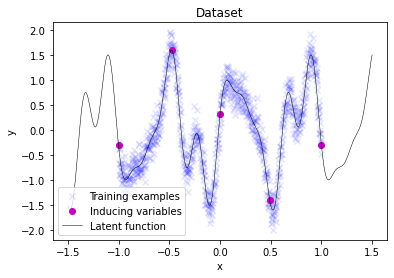

In [ ]:
X_m, indices = select_inducing_points("greedy", X, m, model, jnp.array([100, 100]), model_params)

plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

(10, 1)


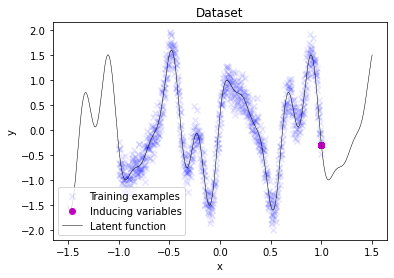

In [5]:
from snngp import init_kernel_fn
from inducing_points import ConditionalVarianceGenerator

kernel_fn = init_kernel_fn(model, jnp.array([4.33574371, 6.78895193]), model_params)
greedy_selector = iter(ConditionalVarianceGenerator(X, m, kernel_fn))
X_m = []
for _ in range(m):
    X_i, i = greedy_selector.__next__()
    X_m.append(X_i)

X_m = jnp.vstack(X_m)
print(X_m.shape)

plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

(10, 1)


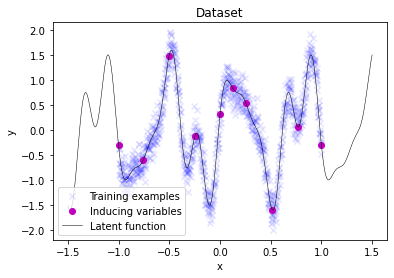

In [15]:
from snngp import init_kernel_fn
from inducing_points import greedy_variance_generator

kernel_fn = init_kernel_fn(model, jnp.array([4.33574371, 6.78895193]), model_params)
greedy_selector = greedy_variance_generator(X, m, kernel_fn)
X_m = []
for _ in range(m):
    X_i, i = next(greedy_selector)
    X_m.append(X_i)

X_m = jnp.vstack(X_m)
print(X_m.shape)

plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# SNNGP Demo

In [5]:
snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X_m, num_latent_gps=1, noise_variance=sigma_y**2, init_stds=jnp.array([1., 1.], dtype=jnp.float64), batch_size=0)

ll = snngp.log_marginal_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ub, ll, ll-lb, ub-lb

(DeviceArray(-8024.98976776, dtype=float64),
 DeviceArray(-8019.62808679, dtype=float64),
 DeviceArray(-8024.79992166, dtype=float64),
 DeviceArray(0.1898461, dtype=float64),
 DeviceArray(5.36168097, dtype=float64))

0.8543281524412933


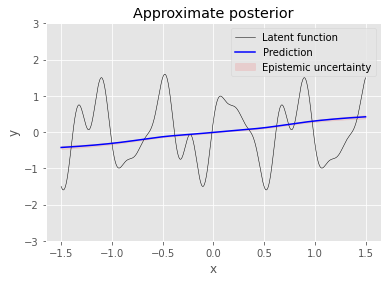

In [6]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
f_test_std = np.sqrt(f_test_cov)
print(RMSE(f_test, f_true))

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.legend()

In [7]:
opt = snngp.optimize(compile=True)
print(opt)
ll = snngp.log_marginal_likelihood()
lb = snngp.lower_bound()
ub = snngp.upper_bound()
lb, ub, ll, ll-lb, ub-lb

[2022-08-15 20:40:44,579 INFO] (snngp:272) Optimizing...
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02499D+03    |proj g|=  1.45190D+04

At iterate    1    f=  1.73575D+03    |proj g|=  1.63404D+03

At iterate    2    f=  1.51683D+03    |proj g|=  1.08594D+03

At iterate    3    f=  8.18641D+02    |proj g|=  6.38075D+02

At iterate    4    f=  7.28006D+02    |proj g|=  6.27046D+02

At iterate    5    f=  6.34724D+02    |proj g|=  6.41842D+02

At iterate    6    f=  1.73103D+02    |proj g|=  5.08702D+02

At iterate    7    f=  4.18326D+01    |proj g|=  5.04589D+02

At iterate    8    f= -2.15416D+01    |proj g|=  4.06628D+02

At iterate    9    f= -9.52912D+01    |proj g|=  7.96341D+01

At iterate   10    f= -9.69835D+01    |proj g|=  5.81722D+01

At iterate   11    f= -9.75375D+01    |proj g|=  2.31163D+01

At iterate   12    f= -9.76858D+01    |proj g|=  6.92105D+00

At iterate   13    f= -9.7

[2022-08-15 20:42:30,015 INFO] (snngp:280) Optimized for 25 iters; Success: True; Result: [1.80660013 1.75239716], 0.03809954758940608



At iterate   25    f= -1.00324D+02    |proj g|=  5.78732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   5.787D-03  -1.003D+02
  F =  -100.32389420844424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(True, DeviceArray([1.80660013, 1.75239716], dtype=float64), DeviceArray(0.03809955, dtype=float64))


(DeviceArray(100.32389421, dtype=float64),
 DeviceArray(109.17372672, dtype=float64),
 DeviceArray(100.33341765, dtype=float64),
 DeviceArray(0.00952344, dtype=float64),
 DeviceArray(8.84983252, dtype=float64))

2.238711672330112


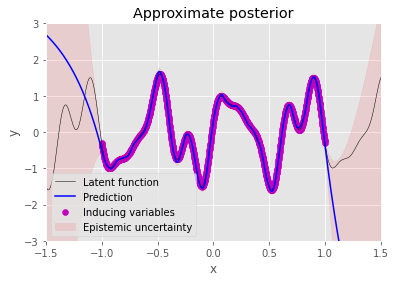

In [8]:
f_test, f_test_cov = snngp.predict(X_test, diag=True)
f_test_std = np.sqrt(f_test_cov)
print(RMSE(f_test, f_true))

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.scatter(snngp.inducing_points, func(snngp.inducing_points), label='Inducing variables', c='m')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std.ravel(), 
                 f_test.ravel() - 2 * f_test_std.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.xlim(-1.5, 1.5)
plt.legend()

# Study the characteristics of hyper-params

In [6]:
for i in [2]:
    stds = jnp.array([5., 20.], dtype=jnp.float64)
    model = FCN
    layer_num = i
    model_params = dict(
                kernel_batch_size=0, 
                device_count=-1, 
                num_layers=layer_num,
                nonlinearity=stax.Relu
                )
    
    snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=X, num_latent_gps=1, noise_variance=sigma_y**2, init_stds=stds)

    lml = snngp.log_marginal_likelihood()
    lb = snngp.lower_bound()
    ub = snngp.upper_bound()
    f_test, f_test_cov = snngp.predict(X_test, diag=True)
    f_test_std = np.sqrt(f_test_cov)

    plt.plot(X_test, f_true, label='Latent function', c='k', linestyle='dotted', lw=0.5)
    plt.plot(X_test, f_test, label='Prediction')
    plt.fill_between(X_test.ravel(), 
                    f_test.ravel() + 2 * f_test_std.ravel(), 
                    f_test.ravel() - 2 * f_test_std.ravel(),
                    label='Epistemic uncertainty',
                    alpha=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-3.0, 3.0)
    plt.legend()
    plt.savefig(f"figures/hyperparams/{stds.tolist()}_{layer_num}_{lml:.4f}_{ub:.4f}_{lb:.4f}.pdf", bbox_inches='tight')
    plt.close()

# Number of inducing points V.S. Boundaries 

In [4]:
select_method = "random"
random_stds = np.array([4.5, 4.8], dtype=np.float64)

stds = random_stds
noise_variance = sigma_y**2
prev_m = 0
lbs, ubs, rmses, lmls = [], [], [], []
nums_inducing_points = np.logspace(1, np.log10(1000), 20)
for m in nums_inducing_points:
    m = round(m)
    if m == prev_m:
        continue
    prev_m = m
    logger.info(f"\n----Number of inducing point: {m}----")
    inducing_points, _ = select_inducing_points(select_method, X, m, model, stds, model_params)
    
    snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=inducing_points, num_latent_gps=1, noise_variance=noise_variance, init_stds=stds, batch_size=0)
    success, stds, noise_variance = snngp.optimize(compile=True, disp=False)
    while not success:
        logger.info("Retry...")
        inducing_points, _ = select_inducing_points(select_method, X, m, model, stds, model_params)
        snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=inducing_points, num_latent_gps=1, noise_variance=noise_variance, init_stds=stds, batch_size=0)
        success, stds, noise_variance = snngp.optimize(compile=True, disp=False)

    lml = snngp.log_marginal_likelihood()
    logger.info(f"LML: {lml:.4f}")
    elbo = snngp.lower_bound()
    logger.info(f"ELBO: {elbo:.4f}")
    eubo = snngp.upper_bound()
    logger.info(f"EUBO: {eubo:.4f}")
    mean, var = snngp.predict(X_test, diag=True)
    logger.debug(f"mean: {mean.shape}; cov: {var.shape}")
    rmse = RMSE(mean, f_true)
    logger.info(f"RMSE: {rmse:.4f}")
    
    lmls.append(lml)
    lbs.append(elbo)
    ubs.append(eubo)
    rmses.append(rmse)


[2022-08-12 06:53:44,562 INFO] (3254153789:14) 
----Number of inducing point: 10----
[2022-08-12 06:53:44,669 INFO] (snngp_inference:59) inducing_points shape: (10, 1)
[2022-08-12 06:53:44,682 INFO] (snngp:272) Optimizing...
[2022-08-12 06:53:48,536 INFO] (snngp:280) Optimized for 24 iters; Success: True; Result: [2.45498769 2.17400076], 0.24900189978073248
[2022-08-12 06:53:49,539 INFO] (3254153789:26) LML: -580.7546
[2022-08-12 06:53:51,930 INFO] (3254153789:28) ELBO: -792.2878
[2022-08-12 06:53:51,972 INFO] (3254153789:30) EUBO: -264.8611
[2022-08-12 06:53:52,187 INFO] (3254153789:34) RMSE: 0.7835
[2022-08-12 06:53:52,188 INFO] (3254153789:14) 
----Number of inducing point: 13----
[2022-08-12 06:53:52,271 INFO] (snngp_inference:59) inducing_points shape: (13, 1)
[2022-08-12 06:53:52,274 INFO] (snngp:272) Optimizing...
[2022-08-12 06:53:55,748 INFO] (snngp:280) Optimized for 13 iters; Success: True; Result: [2.98918946 1.09970968], 0.13762234091715256
[2022-08-12 06:53:56,432 INFO] (

In [10]:
plt.plot(nums_inducing_points, lbs)
plt.plot(nums_inducing_points, lmls, label="log marginal likeli.")
plt.xlabel("Num of inducing points")
plt.ylabel("ELBO")
plt.ylim(-100, 100)
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_{select_method}_fcn_lbs.pdf")
plt.close()
plt.plot(nums_inducing_points, ubs)
plt.plot(nums_inducing_points, lmls, label="log marginal likeli.")
plt.xlabel("Num of inducing points")
plt.ylabel("EUBO")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_{select_method}_fcn_ubs.pdf")
plt.close()
plt.plot(nums_inducing_points, np.array(ubs)-np.array(lbs))
plt.xlabel("Num of inducing points")
plt.ylabel("EUBO-ELBO")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_{select_method}_fcn_ubs-lbs.pdf")
plt.close()
plt.plot(nums_inducing_points, rmses)
plt.xlabel("Num of inducing points")
plt.ylabel("RMSE")
plt.savefig(f"figures/1d_vary_inducing_{select_method}_fcn_rmses.pdf")
plt.close()

REMARK: random selected inducing points can be biased (clustered in one region) which makes the prediction/marginal likelihood worse, especially when the number of inducing points is small.

# Greedy Variance Selection

In [95]:
from snngp import init_kernel_fn
from inducing_points import greedy_variance_generator

init_stds = np.array([4.5, 4.8], dtype=np.float64)

stds = init_stds
noise_variance=sigma_y**2
prev_m = 0
greedy_lbs, greedy_ubs, greedy_rmses, greedy_lmls = [], [], [], []
Zs = []
nums_inducing_points = np.logspace(1, np.log10(100), 10)

kernel_fn = init_kernel_fn(model, stds, model_params)
inducing_generator = greedy_variance_generator(X, 100, kernel_fn)

for m in nums_inducing_points:
    m = round(m)
    if m == prev_m:
        continue
    logger.info(f"\n----Number of inducing point: {m}----")
    for _ in range(m-prev_m):
        Z, _ = next(inducing_generator)
        Zs.append(Z)
    inducing_points = jnp.vstack(Zs)
    logger.info(f"Inducing points shape: {inducing_points.shape}")
    snngp = SNNGP(model=model, hyper_params=model_params, train_data=(X, y), inducing_points=inducing_points, num_latent_gps=1, noise_variance=noise_variance, init_stds=stds, batch_size=0)
    
    success, stds, noise_variance = snngp.optimize(compile=True, disp=False)

    lml = snngp.log_marginal_likelihood()
    logger.info(f"LML: {lml:.4f}")
    elbo = snngp.lower_bound()
    logger.info(f"ELBO: {elbo:.4f}")
    eubo = snngp.upper_bound()
    logger.info(f"EUBO: {eubo:.4f}")
    mean, var = snngp.predict(X_test, diag=True)
    logger.debug(f"mean: {mean.shape}; cov: {var.shape}")
    rmse = RMSE(mean, f_true)
    logger.info(f"RMSE: {rmse:.4f}")
    
    greedy_lmls.append(lml)
    greedy_lbs.append(elbo)
    greedy_ubs.append(eubo)
    greedy_rmses.append(rmse)
    prev_m = m


[2022-08-14 21:26:08,044 INFO] (670804971:20) 
----Number of inducing point: 10----
[2022-08-14 21:26:08,044 INFO] (670804971:20) 
----Number of inducing point: 10----
[2022-08-14 21:26:10,178 INFO] (670804971:25) Inducing points shape: (10, 1)
[2022-08-14 21:26:10,178 INFO] (670804971:25) Inducing points shape: (10, 1)
[2022-08-14 21:26:10,194 INFO] (snngp:272) Optimizing...
[2022-08-14 21:26:10,194 INFO] (snngp:272) Optimizing...
[2022-08-14 21:26:14,993 INFO] (snngp:280) Optimized for 22 iters; Success: True; Result: [2.9364608 2.3614361], 0.2681465996026195
[2022-08-14 21:26:14,993 INFO] (snngp:280) Optimized for 22 iters; Success: True; Result: [2.9364608 2.3614361], 0.2681465996026195
[2022-08-14 21:26:16,204 INFO] (670804971:31) LML: -95.2980
[2022-08-14 21:26:16,204 INFO] (670804971:31) LML: -95.2980
[2022-08-14 21:26:19,985 INFO] (670804971:33) ELBO: -102.4315
[2022-08-14 21:26:19,985 INFO] (670804971:33) ELBO: -102.4315
[2022-08-14 21:26:20,030 INFO] (670804971:35) EUBO: -58.

In [100]:
# plt.plot(nums_inducing_points, lbs, label="random")
plt.plot(nums_inducing_points, greedy_lbs, label="greedy")
plt.plot(nums_inducing_points, greedy_lmls, label="log marginal likeli.")
plt.xlabel("Num of inducing points")
plt.ylabel("ELBO")
# plt.ylim(-100, 100)
plt.xscale('log')
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_greedy_fcn_lbs.pdf")
plt.close()
# plt.plot(nums_inducing_points, ubs, label="random")
plt.plot(nums_inducing_points, greedy_ubs, label="greedy")
plt.plot(nums_inducing_points, greedy_lmls, label="log marginal likeli.")
plt.xlabel("Num of inducing points")
plt.ylabel("EUBO")
plt.xscale('log')
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_greedy_fcn_ubs.pdf")
plt.close()
# plt.plot(nums_inducing_points, np.array(ubs)-np.array(lbs), label="random")
plt.plot(nums_inducing_points, np.array(greedy_ubs)-np.array(greedy_lbs), label="greedy")
plt.xlabel("Num of inducing points")
plt.ylabel("EUBO-ELBO")
plt.xscale('log')
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_greedy_fcn_ubs-lbs.pdf")
plt.close()
plt.plot(nums_inducing_points, np.array(greedy_lmls)-np.array(greedy_lbs), label="greedy")
plt.xlabel("Num of inducing points")
plt.ylabel("KL")
plt.xscale('log')
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_greedy_fcn_kl.pdf")
plt.close()
# plt.plot(nums_inducing_points, rmses, label="random")
plt.plot(nums_inducing_points, greedy_rmses, label="greedy")
plt.xlabel("Num of inducing points")
plt.ylabel("RMSE")
plt.xscale('log')
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_greedy_fcn_rmses.pdf")
plt.close()

# Random v.s. Greedy

In [23]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('ggplot')

with open("important_logs/vary_inducing_random_fcn_1d_opt.log") as f:
    lmls, lbs, ubs, rmses, sigmas = [], [], [], [], []
    nums_inducing_points = []
    for line in f:
        line = line.strip()
        if "Number of inducing point" in line:
            num = int(line.split(": ")[-1].strip("----"))
            nums_inducing_points.append(num)
        elif "LML" in line:
            lml = float(line.split(": ")[-1].strip())
            lmls.append(lml)
        elif "ELBO" in line:
            elbo = float(line.split(": ")[-1].strip())
            lbs.append(elbo)
        elif "EUBO" in line:
            eubo = float(line.split(": ")[-1].strip())
            ubs.append(eubo)
        elif "RMSE" in line:
            rmse = float(line.split(": ")[-1].strip())
            rmses.append(rmse)
        elif "Success: True" in line:
            sigma = float(line.split("Result: [")[-1].split(" ")[0])
            sigmas.append(sigma)
            
with open("important_logs/vary_inducing_greedy_fcn_1d_opt.log") as f:
    greedy_lmls, greedy_lbs, greedy_ubs, greedy_rmses, greedy_sigmas = [], [], [], [], []
    nums_inducing_points = []
    for line in f:
        line = line.strip()
        if "Number of inducing point" in line:
            num = int(line.split(": ")[-1].strip("----"))
            nums_inducing_points.append(num)
        elif "LML" in line:
            lml = float(line.split(": ")[-1].strip())
            greedy_lmls.append(lml)
        elif "ELBO" in line:
            elbo = float(line.split(": ")[-1].strip())
            greedy_lbs.append(elbo)
        elif "EUBO" in line:
            eubo = float(line.split(": ")[-1].strip())
            greedy_ubs.append(eubo)
        elif "RMSE" in line:
            rmse = float(line.split(": ")[-1].strip())
            greedy_rmses.append(rmse)
        elif "Success" in line:
            sigma = float(line.split("Result: [")[-1].split(" ")[0])
            greedy_sigmas.append(sigma)

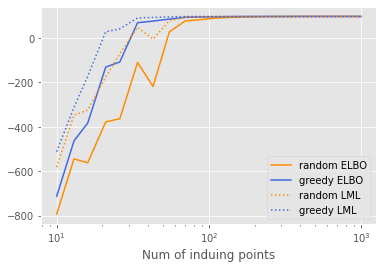

In [24]:
plt.plot(nums_inducing_points, lbs, label="random ELBO", color='darkorange')
plt.plot(nums_inducing_points, greedy_lbs, label="greedy ELBO", color='royalblue')
plt.plot(nums_inducing_points, lmls, label="random LML", linestyle="dotted", color='darkorange')
plt.plot(nums_inducing_points, greedy_lmls, label="greedy LML", linestyle="dotted", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_lbs.pdf", bbox_inches='tight')

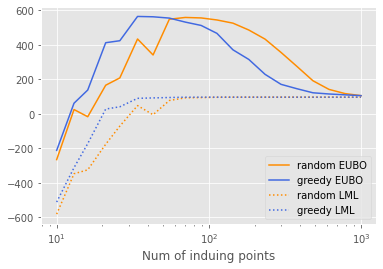

In [25]:
plt.plot(nums_inducing_points, ubs, label="random EUBO", color='darkorange')
plt.plot(nums_inducing_points, greedy_ubs, label="greedy EUBO", color='royalblue')
plt.plot(nums_inducing_points, lmls, label="random LML", linestyle="dotted", color='darkorange')
plt.plot(nums_inducing_points, greedy_lmls, label="greedy LML", linestyle="dotted", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_ubs.pdf", bbox_inches='tight')

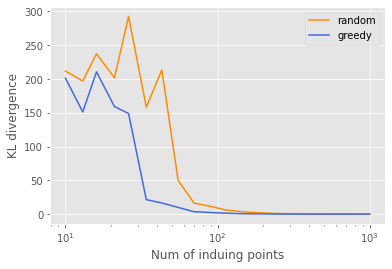

In [26]:
kl = np.array(lmls) - np.array(lbs)
greedy_kl = np.array(greedy_lmls) - np.array(greedy_lbs)
plt.plot(nums_inducing_points, kl, label="random", color='darkorange')
plt.plot(nums_inducing_points, greedy_kl, label="greedy", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.ylabel("KL divergence")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_kl.pdf", bbox_inches='tight')

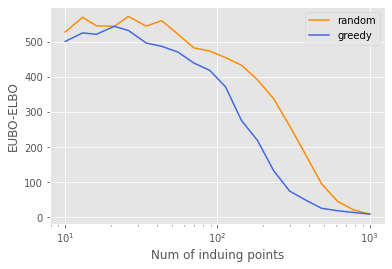

In [27]:
plt.plot(nums_inducing_points, np.array(ubs) - np.array(lbs), label="random", color='darkorange')
plt.plot(nums_inducing_points, np.array(greedy_ubs) - np.array(greedy_lbs), label="greedy", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.ylabel("EUBO-ELBO")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_ubs-lbs.pdf", bbox_inches='tight')

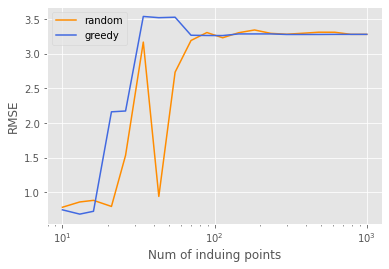

In [31]:
plt.plot(nums_inducing_points, rmses, label="random", color='darkorange')
plt.plot(nums_inducing_points, greedy_rmses, label="greedy", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_rmses.pdf", bbox_inches='tight')

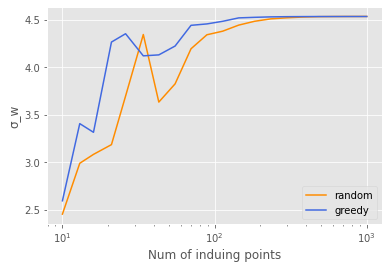

In [32]:
plt.plot(nums_inducing_points, sigmas, label="random", color='darkorange')
plt.plot(nums_inducing_points, greedy_sigmas, label="greedy", color='royalblue')
plt.xscale('log')
plt.xlabel("Num of induing points")
plt.ylabel("\u03C3_w")
plt.legend()
plt.savefig(f"figures/1d_vary_inducing_sigmas.pdf", bbox_inches='tight')